Support Vector Machine

In [12]:
pip freeze > model_requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, hinge_loss, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.ensemble import RandomForestClassifier

Import data

In [14]:
#SMOTE min but no scaling
data_train_df = pd.read_csv("data_train_csv")
data_smin_train_df = pd.read_csv("data_smin_train_csv")
data_test_df = pd.read_csv("data_test_csv")
data_val_df = pd.read_csv("data_val_csv")

In [15]:
#DL data.  SMOTE but only with the predictors/ independent variables that DL method uses
dl_train_df = data_train_df[['Wickets taken', 'Remainder', 'Winner_num']]
dl_test_df = data_test_df[['Wickets taken', 'Remainder', 'Winner_num']]
dl_val_df = data_val_df[['Wickets taken', 'Remainder', 'Winner_num']]

In [16]:
#SMOTE and minmax scaled
data_mm_train_df = pd.read_csv('data_smin_mm_train_csv')
data_mm_test_df = pd.read_csv('data_mm_test_csv')
data_mm_val_df = pd.read_csv('data_mm_val_csv')

In [17]:
#SMOTE and StandardScaler
data_ss_train_df = pd.read_csv('data_smin_ss_train_csv')
data_ss_test_df = pd.read_csv('data_ss_test_csv')
data_ss_val_df = pd.read_csv('data_ss_val_csv')

In [18]:
print(f"Data_train: {data_mm_train_df.shape}")
print(f"Data_test: {data_mm_test_df.shape}")
print(f"Data_val: {data_mm_val_df.shape}")

#Divide by 10 for the sample

Data_train: (296133, 9)
Data_test: (27782, 9)
Data_val: (55563, 9)


Split into X and ys

In [19]:
#own module which takes in df for train, test and val and returns in x and y format.  Can also sample.
from data_formatting import data_format

In [20]:
X_mm_train_sample, X_mm_test_sample, X_mm_val_sample, y_mm_train_sample, y_mm_test_sample, y_mm_val_sample = data_format(data_mm_train_df, data_mm_test_df, data_mm_val_df, 'sample', 20)
X_ss_train_sample, X_ss_test_sample, X_ss_val_sample, y_ss_train_sample, y_ss_test_sample, y_ss_val_sample = data_format(data_ss_train_df, data_ss_test_df, data_ss_val_df, 'sample', 20)

In [21]:
X_ss_train, X_ss_test, X_ss_val, y_ss_train, y_ss_test, y_ss_val = data_format(data_ss_train_df, data_ss_test_df, data_ss_val_df, None, None)
X_mm_train, X_mm_test, X_mm_val, y_mm_train, y_mm_test, y_mm_val = data_format(data_mm_train_df, data_mm_test_df, data_mm_val_df, None, None)

In [22]:
X_dl_train, X_dl_test, X_dl_val, y_dl_train, y_dl_test, y_dl_val = data_format(dl_train_df, dl_test_df, dl_val_df, None, None)

In [23]:
X_smin_train, X_smin_test, X_smin_val, y_smin_train, y_smin_test, y_smin_val = data_format(data_smin_train_df, data_test_df, data_val_df, None, None)

SVM model

In [24]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

Feature selection

Used Pearson correlation to show where the highly correlated areas were, and removed anything above 0.8

<Axes: >

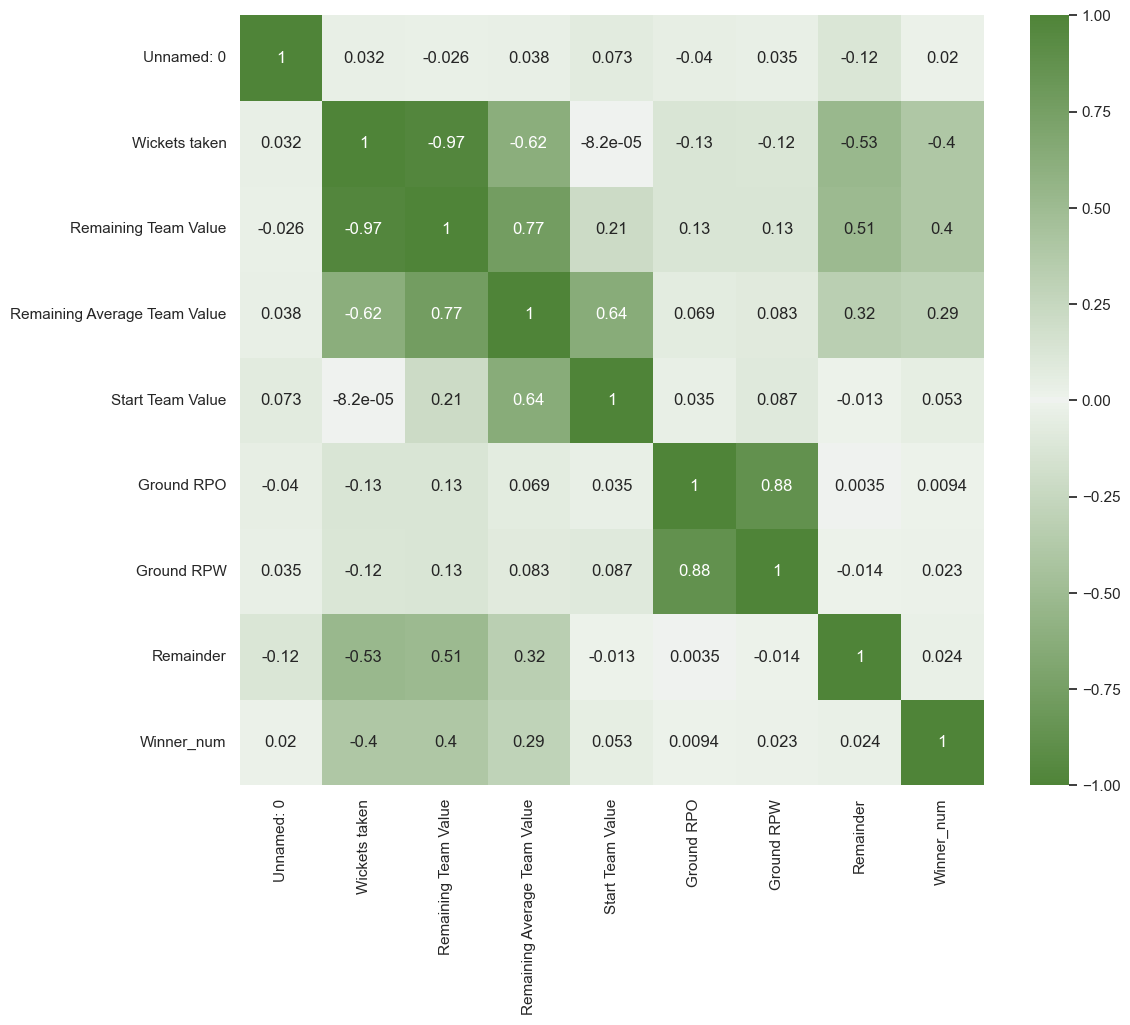

In [25]:
corr_matrix = data_ss_train_df.corr(method = 'pearson')
sns.set(rc={'figure.figsize':(12,10)})
new_cmap = sns.diverging_palette(120, 120, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, cmap=new_cmap, vmin=-1, vmax=1)

Used Random Forest to show feature importance

In [26]:
model = RandomForestClassifier(n_jobs=-1, random_state=7)
model.fit(X_ss_train, y_ss_train)

RandomForestClassifier(n_jobs=-1, random_state=7)

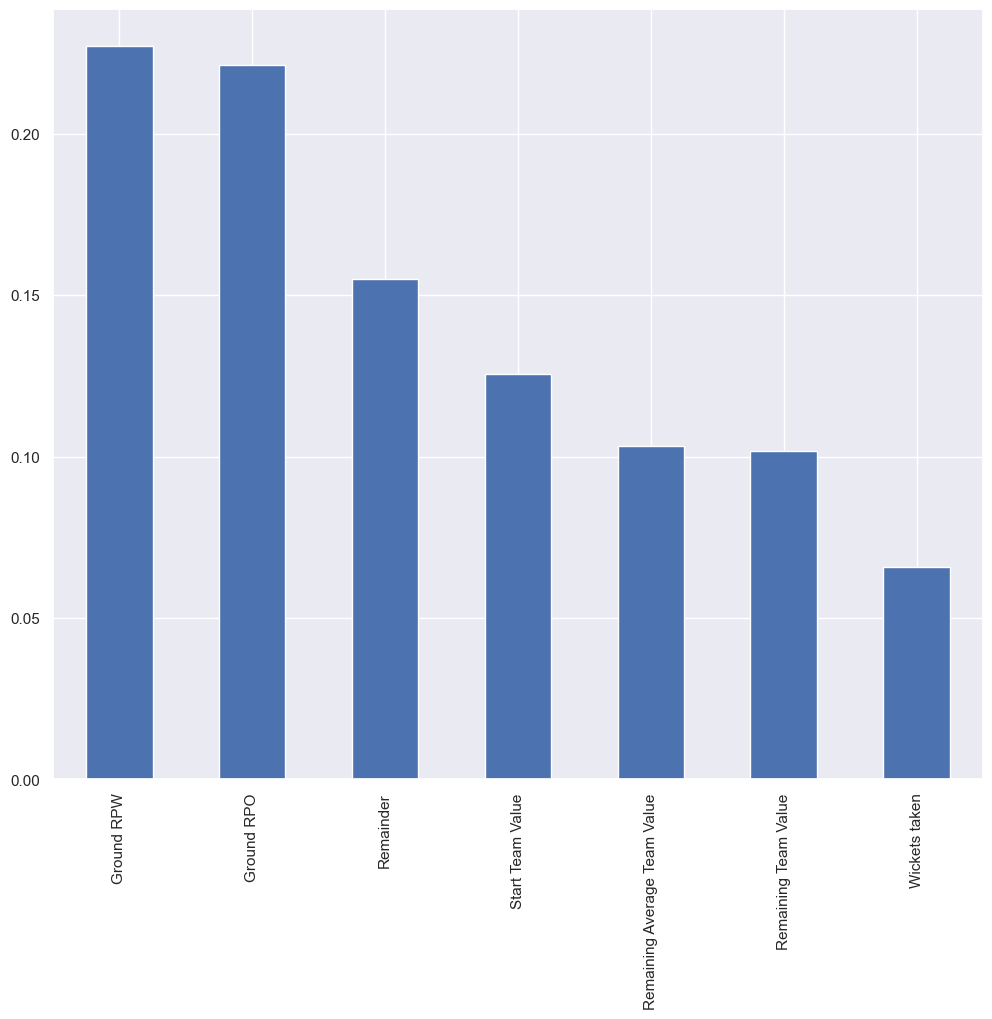

In [27]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(model.feature_importances_, index=X_ss_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

Saved dataframes with dropped features depending on the feature selection techniques

In [28]:
# Feature selection Correlation
data_ss_corr_train_df = data_ss_train_df.drop(columns=['Remaining Team Value', 'Ground RPO'])
data_ss_corr_test_df = data_ss_test_df.drop(columns=['Remaining Team Value', 'Ground RPO'])
data_ss_corr_val_df = data_ss_val_df.drop(columns=['Remaining Team Value', 'Ground RPO'])

X_ss_corr_train, X_ss_corr_test, X_ss_corr_val, y_ss_corr_train, y_ss_corr_test, y_ss_corr_val = data_format(data_ss_corr_train_df, data_ss_corr_test_df, data_ss_corr_val_df, None, None)
X_ss_corr_train_sample, X_ss_corr_test_sample, X_ss_corr_val_sample, y_ss_corr_train_sample, y_ss_corr_test_sample, y_ss_corr_val_sample = data_format(data_ss_corr_train_df, data_ss_corr_test_df, data_ss_corr_val_df, 'sample',20)

RF - wouldn't want to remove Wickets taken as that isn't building on DL it would be changing it, so with domain knowledge the two to drop would be the same as above.

In [29]:
#Feature selection RF without domain knowledge
data_ss_rfl_train_df = data_ss_train_df.drop(columns=['Remaining Average Team Value', 'Wickets taken'])
data_ss_rfl_test_df = data_ss_test_df.drop(columns=['Remaining Average Team Value', 'Wickets taken'])
data_ss_rfl_val_df = data_ss_val_df.drop(columns=['Remaining Average Team Value', 'Wickets taken'])

X_ss_rfl_train, X_ss_rfl_test, X_ss_rfl_val, y_ss_rfl_train, y_ss_rfl_test, y_ss_rfl_val = data_format(data_ss_rfl_train_df, data_ss_rfl_test_df, data_ss_rfl_val_df, None, None)
X_ss_rfl_train_sample, X_ss_rfl_test_sample, X_ss_rfl_val_sample, y_ss_rfl_train_sample, y_ss_rf_test_sample, y_ss_rfl_val_sample = data_format(data_ss_rfl_train_df, data_ss_rfl_test_df, data_ss_rfl_val_df, 'sample',20)

Created baseline SVCs for each type of data

In [30]:
labels = ['Team 1', 'Tie', 'Team 2']

Training score: 0.7264487722611299, Testing score: 0.7279173565618026, Time to train: 1677.00710105896 seconds


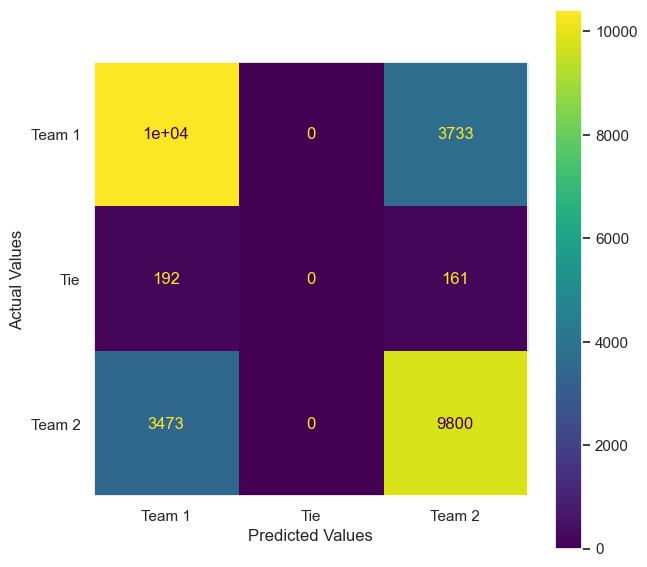

              precision    recall  f1-score   support

      Team 1       0.74      0.74      0.74     14156
         Tie       0.00      0.00      0.00       353
      Team 2       0.72      0.74      0.73     13273

    accuracy                           0.73     27782
   macro avg       0.49      0.49      0.49     27782
weighted avg       0.72      0.73      0.72     27782



C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469

In [31]:
#DL data

start_time = time.time()

model = SVC(kernel="linear", random_state=7)
model.fit(X_dl_train, y_dl_train)

model_train_score = model.score(X_dl_train, y_dl_train)
model_test_score = model.score(X_dl_test, y_dl_test)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training score: {model_train_score}, Testing score: {model_test_score}, Time to train: {elapsed_time} seconds" )

y_pred = model.predict(X_dl_test)

cm = confusion_matrix(y_dl_test, y_pred, labels=model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(7,7))
cmd.plot(ax=ax)
plt.grid(False)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

print(classification_report(y_dl_test, y_pred, target_names=labels))

SMOTE data no scaling - took too long to run (was still running at nearly 24 hours for 1 model)

start_time = time.time()

model = SVC(kernel="linear", random_state=7)
model.fit(X_smin_train, y_smin_train)

model_train_score = model.score(X_smin_train, y_smin_train)
model_test_score = model.score(X_smin_test, y_smin_test)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training score: {model_train_score}, Testing score: {model_test_score}, Time to train: {elapsed_time} seconds" )

y_pred = model.predict(X_smin_test)

cm = confusion_matrix(y_smin_test, y_pred, labels=model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(7,7))
cmd.plot(ax=ax)
plt.grid(False)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

print(classification_report(y_smin_test, y_pred, target_names=labels))

Training score: 0.5369614328696903, Testing score: 0.6011086314880139, Time to train: 2834.1844453811646 seconds


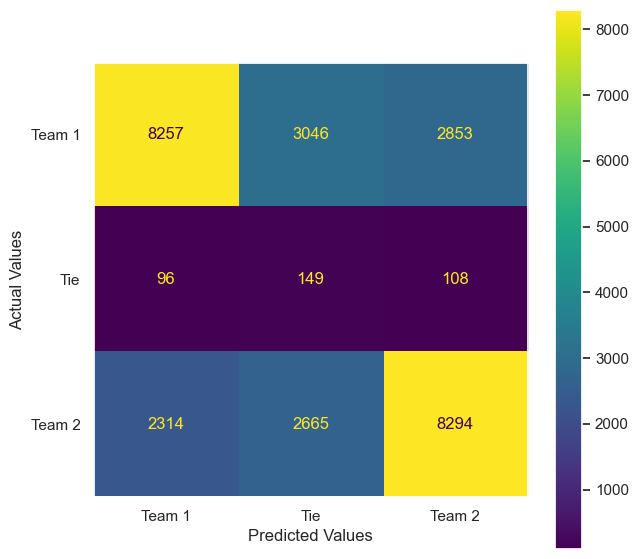

              precision    recall  f1-score   support

      Team 1       0.77      0.58      0.67     14156
         Tie       0.03      0.42      0.05       353
      Team 2       0.74      0.62      0.68     13273

    accuracy                           0.60     27782
   macro avg       0.51      0.54      0.46     27782
weighted avg       0.75      0.60      0.66     27782



In [32]:
##SS and SMOTE data

start_time = time.time()

model = SVC(kernel="linear", random_state=7)
model.fit(X_ss_train, y_ss_train)

model_train_score = model.score(X_ss_train, y_ss_train)
model_test_score = model.score(X_ss_test, y_ss_test)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training score: {model_train_score}, Testing score: {model_test_score}, Time to train: {elapsed_time} seconds" )

y_pred = model.predict(X_ss_test)

cm = confusion_matrix(y_ss_test, y_pred, labels=model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(7,7))
cmd.plot(ax=ax)
plt.grid(False)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

print(classification_report(y_ss_test, y_pred, target_names=labels))

Training score: 0.5391969148997241, Testing score: 0.6042761500251962, Time to train: 4970.865523099899 seconds


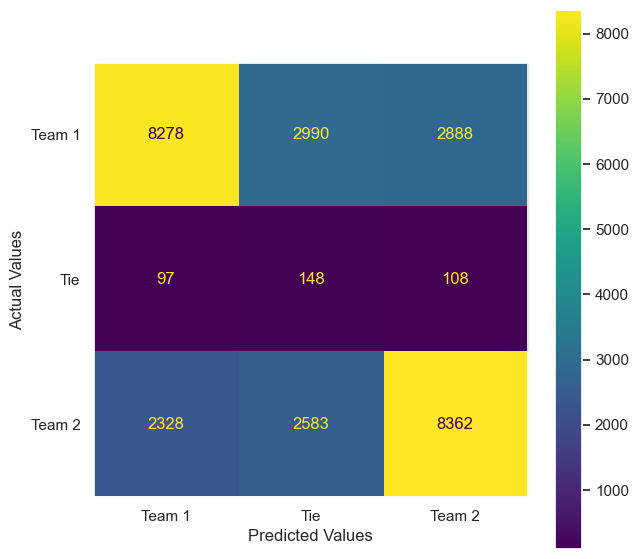

              precision    recall  f1-score   support

      Team 1       0.77      0.58      0.67     14156
         Tie       0.03      0.42      0.05       353
      Team 2       0.74      0.63      0.68     13273

    accuracy                           0.60     27782
   macro avg       0.51      0.54      0.46     27782
weighted avg       0.75      0.60      0.66     27782



In [33]:
##MM and SMOTE data
model = SVC(kernel="linear", random_state=7)
model.fit(X_mm_train, y_mm_train)

model_train_score = model.score(X_mm_train, y_mm_train)
model_test_score = model.score(X_mm_test, y_mm_test)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training score: {model_train_score}, Testing score: {model_test_score}, Time to train: {elapsed_time} seconds" )

y_pred = model.predict(X_mm_test)

cm = confusion_matrix(y_mm_test, y_pred, labels=model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(7,7))
cmd.plot(ax=ax)
plt.grid(False)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

print(classification_report(y_mm_test, y_pred, target_names=labels))

Hyperparameter tuning

Tuned SVCs on the lists below as a grid

In [35]:
k_list = ['rbf', 'sigmoid']
#Not poly because it takes so long and not linear as relationship isn't linear (see SVM above)
gamma_list = [0.001, 0.01, 0.1, 1, 10, 100, 250, 500, 750]
c_list = [0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400, 500]

In [ ]:
print("MM")
best_accuracy = 0
best_loss = 100

for k in k_list:
    for gamma in gamma_list:
        for c in c_list:

            start_time = time.time()
            
            # for each combination of parameters, train an SVC
            model = SVC(kernel=k, gamma=gamma, C=c, random_state=7)
            model.fit(X_mm_train_sample, y_mm_train_sample)
            y_train_pred = model.predict(X_mm_train_sample)
            y_val_pred = model.predict(X_mm_val_sample)

            train_accuracy = accuracy_score(y_mm_train_sample, y_train_pred)
            val_accuracy = accuracy_score(y_mm_val_sample, y_val_pred)

            train_loss = hinge_loss(y_mm_train_sample, model.decision_function(X_mm_train_sample))
            val_loss = hinge_loss(y_mm_val_sample, model.decision_function(X_mm_val_sample))

            end_time = time.time()
            elapsed_time = end_time - start_time

            print(f"{k}, Gamma: {gamma}, C: {c}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Time to train: {elapsed_time} seconds")


            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_acc_parameters = {'C': c, 'gamma': gamma, 'kernel': k}

            if val_loss < best_loss:
                best_loss = val_loss
                best_loss_parameters = {'C': c, 'gamma': gamma, 'kernel': k}

print(f"Best accuracy is: {best_accuracy} and best parameters are {best_acc_parameters}")
print(f"Best loss is: {best_loss} and best parameters are {best_loss_parameters}")

MM
rbf, Gamma: 0.001, C: 0.001, Train Accuracy: 0.34053761988383086, Validation Accuracy: 0.009359251259899209, Train Loss: 1.8576226335393367, Validation Loss: 2.791359803504446, Time to train: 50.753623723983765 seconds
rbf, Gamma: 0.001, C: 0.01, Train Accuracy: 0.34053761988383086, Validation Accuracy: 0.009359251259899209, Train Loss: 1.8571445789832777, Validation Loss: 2.7906726867587723, Time to train: 50.8405704498291 seconds
rbf, Gamma: 0.001, C: 0.1, Train Accuracy: 0.34053761988383086, Validation Accuracy: 0.009359251259899209, Train Loss: 1.8510578632129342, Validation Loss: 2.7817836178691553, Time to train: 48.626461029052734 seconds
rbf, Gamma: 0.001, C: 1, Train Accuracy: 0.5135080372821829, Validation Accuracy: 0.5637149028077754, Train Loss: 1.2537296194095442, Validation Loss: 1.2348191809569784, Time to train: 48.09118628501892 seconds
rbf, Gamma: 0.001, C: 10, Train Accuracy: 0.5340402539511009, Validation Accuracy: 0.5971922246220303, Train Loss: 1.19727511912489

In [ ]:
print("SS")
best_accuracy = 0
best_loss = 100

for k in k_list:
    for gamma in gamma_list:
        for c in c_list:

            start_time = time.time()
            
            # for each combination of parameters, train an SVC
            model = SVC(kernel=k, gamma=gamma, C=c, random_state=7)
            model.fit(X_ss_train_sample, y_ss_train_sample)
            y_train_pred = model.predict(X_ss_train_sample)
            y_val_pred = model.predict(X_ss_val_sample)

            train_accuracy = accuracy_score(y_ss_train_sample, y_train_pred)
            val_accuracy = accuracy_score(y_ss_val_sample, y_val_pred)

            train_loss = hinge_loss(y_ss_train_sample, model.decision_function(X_ss_train_sample))
            val_loss = hinge_loss(y_ss_val_sample, model.decision_function(X_ss_val_sample))

            end_time = time.time()
            elapsed_time = end_time - start_time

            print(f"{k}, Gamma: {gamma}, C: {c}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Time to train: {elapsed_time} seconds")
            
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_acc_parameters = {'C': c, 'gamma': gamma, 'kernel': k}

            if val_loss < best_loss:
                best_loss = val_loss
                best_loss_parameters = {'C': c, 'gamma': gamma, 'kernel': k}

print(f"Best accuracy is: {best_accuracy} and best parameters are {best_acc_parameters}")
print(f"Best loss is: {best_loss} and best parameters are {best_loss_parameters}")

SS
rbf, Gamma: 0.001, C: 0.001, Train Accuracy: 0.34053761988383086, Validation Accuracy: 0.009359251259899209, Train Loss: 1.8567259968907486, Validation Loss: 2.7900798351914773, Time to train: 54.668997287750244 seconds
rbf, Gamma: 0.001, C: 0.01, Train Accuracy: 0.34053761988383086, Validation Accuracy: 0.009359251259899209, Train Loss: 1.8393406770820142, Validation Loss: 2.7643840962963013, Time to train: 52.72057366371155 seconds
rbf, Gamma: 0.001, C: 0.1, Train Accuracy: 0.5065513980818587, Validation Accuracy: 0.6227501799856011, Train Loss: 1.259814439886818, Validation Loss: 1.103762281245536, Time to train: 49.92802548408508 seconds
rbf, Gamma: 0.001, C: 1, Train Accuracy: 0.548966635147913, Validation Accuracy: 0.6184305255579554, Train Loss: 1.17469213580186, Validation Loss: 1.0736575031281195, Time to train: 47.11631393432617 seconds
rbf, Gamma: 0.001, C: 10, Train Accuracy: 0.5651087397001215, Validation Accuracy: 0.6123110151187905, Train Loss: 1.119454049607681, Vali

StandardScaler showed better accuracy so next compared these to feature selected versions

In [ ]:
print("SS with Feature Selection Pearson's Correlation")
best_accuracy = 0
best_loss = 100

for k in k_list:
    for gamma in gamma_list:
        for c in c_list:

            start_time = time.time()
            
            # for each combination of parameters, train an SVC
            model = SVC(kernel=k, gamma=gamma, C=c, random_state=7)
            model.fit(X_ss_corr_train_sample, y_ss_corr_train_sample)
            y_train_pred = model.predict(X_ss_corr_train_sample)
            y_val_pred = model.predict(X_ss_corr_val_sample)

            train_accuracy = accuracy_score(y_ss_corr_train_sample, y_train_pred)
            val_accuracy = accuracy_score(y_ss_corr_val_sample, y_val_pred)

            train_loss = hinge_loss(y_ss_corr_train_sample, model.decision_function(X_ss_corr_train_sample))
            val_loss = hinge_loss(y_ss_corr_val_sample, model.decision_function(X_ss_corr_val_sample))

            end_time = time.time()
            elapsed_time = end_time - start_time

            print(f"{k}, Gamma: {gamma}, C: {c}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Time to train: {elapsed_time} seconds")

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_acc_parameters = {'C': c, 'gamma': gamma, 'kernel': k}

            if val_loss < best_loss:
                best_loss = val_loss
                best_loss_parameters = {'C': c, 'gamma': gamma, 'kernel': k}

print(f"Best accuracy is: {best_accuracy} and best parameters are {best_acc_parameters}")
print(f"Best loss is: {best_loss} and best parameters are {best_loss_parameters}")

SS with Feature Selection Pearson's Correlation
rbf, Gamma: 0.001, C: 0.001, Train Accuracy: 0.34053761988383086, Validation Accuracy: 0.009359251259899209, Train Loss: 1.8568354700187013, Validation Loss: 2.7902013250265707, Time to train: 52.39489197731018 seconds
rbf, Gamma: 0.001, C: 0.01, Train Accuracy: 0.34053761988383086, Validation Accuracy: 0.009359251259899209, Train Loss: 1.8461696202771654, Validation Loss: 2.7743440659727137, Time to train: 51.91655254364014 seconds
rbf, Gamma: 0.001, C: 0.1, Train Accuracy: 0.4958800486289342, Validation Accuracy: 0.5914326853851691, Train Loss: 1.2987045721287334, Validation Loss: 1.1673487103255822, Time to train: 51.08438277244568 seconds
rbf, Gamma: 0.001, C: 1, Train Accuracy: 0.5361339997298392, Validation Accuracy: 0.6108711303095752, Train Loss: 1.20864892166133, Validation Loss: 1.0989270298237512, Time to train: 47.38788390159607 seconds
rbf, Gamma: 0.001, C: 10, Train Accuracy: 0.5464001080642983, Validation Accuracy: 0.622390

In [36]:
#Feature selected rf removing least important 2 features
print("SS With Feature Selection RF without domain knowledge")
best_accuracy = 0
best_loss = 100

for k in k_list:
    for gamma in gamma_list:
        for c in c_list:

            start_time = time.time()
            
            # for each combination of parameters, train an SVC
            model = SVC(kernel=k, gamma=gamma, C=c, random_state=7)
            model.fit(X_ss_rfl_train_sample, y_ss_rfl_train_sample)
            y_train_pred = model.predict(X_ss_rfl_train_sample)
            y_val_pred = model.predict(X_ss_rfl_val_sample)

            train_accuracy = accuracy_score(y_ss_rfl_train_sample, y_train_pred)
            val_accuracy = accuracy_score(y_ss_rfl_val_sample, y_val_pred)

            train_loss = hinge_loss(y_ss_rfl_train_sample, model.decision_function(X_ss_rfl_train_sample))
            val_loss = hinge_loss(y_ss_rfl_val_sample, model.decision_function(X_ss_rfl_val_sample))

            end_time = time.time()
            elapsed_time = end_time - start_time

            print(f"{k}, Gamma: {gamma}, C: {c}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Time to train: {elapsed_time} seconds")


            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_acc_parameters = {'C': c, 'gamma': gamma, 'kernel': k}

            if val_loss < best_loss:
                best_loss = val_loss
                best_loss_parameters = {'C': c, 'gamma': gamma, 'kernel': k}

print(f"Best accuracy is: {best_accuracy} and best parameters are {best_acc_parameters}")
print(f"Best loss is: {best_loss} and best parameters are {best_loss_parameters}")

SS With Feature Selection RF without domain knowledge
rbf, Gamma: 0.001, C: 0.001, Train Accuracy: 0.34053761988383086, Validation Accuracy: 0.009359251259899209, Train Loss: 1.8566511295388057, Validation Loss: 2.7899369434939016, Time to train: 104.95000743865967 seconds
rbf, Gamma: 0.001, C: 0.01, Train Accuracy: 0.34053761988383086, Validation Accuracy: 0.009359251259899209, Train Loss: 1.8464801507277033, Validation Loss: 2.7749514444275674, Time to train: 53.64227795600891 seconds
rbf, Gamma: 0.001, C: 0.1, Train Accuracy: 0.5195866540591652, Validation Accuracy: 0.5903527717782577, Train Loss: 1.232178351772268, Validation Loss: 1.121021418078362, Time to train: 111.606196641922 seconds
rbf, Gamma: 0.001, C: 1, Train Accuracy: 0.5401188707280832, Validation Accuracy: 0.6000719942404608, Train Loss: 1.194271411720669, Validation Loss: 1.107509657598725, Time to train: 128.80701422691345 seconds
rbf, Gamma: 0.001, C: 10, Train Accuracy: 0.5538970687559097, Validation Accuracy: 0.6

Tuned the hyperparameters in more detail

Use the best combination for ss data, without feature selection as it had the highest accuracy.

Best parameters {'C': 200, 'gamma': 1, 'kernel': 'rbf'}

In [38]:
gammas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4,2.5, 2.6, 2.7, 2.8]

In [39]:
best_accuracy=0
best_loss = 100
c_list= []
g_list=[]
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for c in range(100, 301, 10):
    for g in gammas:
        c_list.append(c)
        g_list.append(g)

        start_time = time.time()
            
        # for each combination of parameters, train an SVC
        model = SVC(kernel='rbf', gamma=g, C=c, random_state=7)
        model.fit(X_ss_train_sample, y_ss_train_sample)

        y_train_pred = model.predict(X_ss_train_sample)
        y_val_pred = model.predict(X_ss_val_sample)

        train_accuracy = accuracy_score(y_ss_train_sample, y_train_pred)
        val_accuracy = accuracy_score(y_ss_val_sample, y_val_pred)

        train_loss = hinge_loss(y_ss_train_sample, model.decision_function(X_ss_train_sample))
        val_loss = hinge_loss(y_ss_val_sample, model.decision_function(X_ss_val_sample))

        end_time = time.time()
        elapsed_time = end_time - start_time
        
        print(f"{c} C, {g} Gamma, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Time taken to train: {elapsed_time}")

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_acc_c = c
            best_acc_g = g

        if val_loss< best_loss:
            best_loss = val_loss
            best_loss_c = c
            best_loss_g = g

print(f"Best accuracy is: {best_accuracy}, C is {best_acc_c} and Gamma is {best_acc_g}")
print(f"Best accuracy is: {best_loss}, C is {best_loss_c} and Gamma is {best_loss_g}")

100 C, 0.1 Gamma, Train Accuracy: 0.8148048088612725, Validation Accuracy: 0.701223902087833, Train Loss: 0.41679371781955465, Validation Loss: 0.6728230122638119, Time taken to train: 33.10312366485596
100 C, 0.2 Gamma, Train Accuracy: 0.8567472646224503, Validation Accuracy: 0.7458603311735061, Train Loss: 0.3093539053134671, Validation Loss: 0.5548912222711007, Time taken to train: 28.92984628677368
100 C, 0.3 Gamma, Train Accuracy: 0.8819397541537215, Validation Accuracy: 0.7854571634269258, Train Loss: 0.2496840778540165, Validation Loss: 0.4628856862310116, Time taken to train: 23.93521499633789
100 C, 0.4 Gamma, Train Accuracy: 0.9001756044846684, Validation Accuracy: 0.793016558675306, Train Loss: 0.20980623720513997, Validation Loss: 0.4410678866089287, Time taken to train: 25.206549406051636
100 C, 0.5 Gamma, Train Accuracy: 0.9151019856814805, Validation Accuracy: 0.8063354931605472, Train Loss: 0.17766768425170787, Validation Loss: 0.4123477433679033, Time taken to train: 2

Trained final model using best combination
kernel = rbf, C=200, gamma=1.6

Train Accuracy: 0.9576474084279699, Val Accuracy: 0.931375195723773, Test Accuracy: 0.9275790079907854


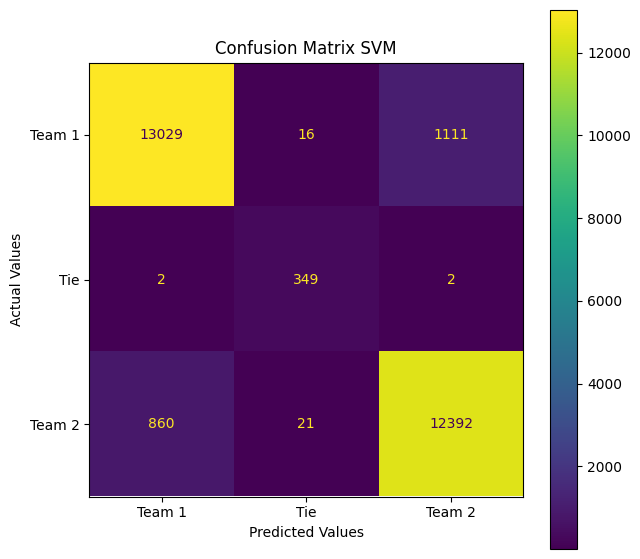

              precision    recall  f1-score   support

      Team 1       0.94      0.92      0.93     14156
         Tie       0.90      0.99      0.94       353
      Team 2       0.92      0.93      0.93     13273

    accuracy                           0.93     27782
   macro avg       0.92      0.95      0.93     27782
weighted avg       0.93      0.93      0.93     27782



In [28]:
final_model= SVC(kernel="rbf", random_state=7, C=200, gamma=1.6)
final_model.fit(X_ss_train, y_ss_train)

y_train_pred = final_model.predict(X_ss_train)
y_val_pred = final_model.predict(X_ss_val)
y_test_pred = final_model.predict(X_ss_test)

# Model Accuracy: how often is the classifier correct?
print(f"Train Accuracy: {accuracy_score(y_ss_train, y_train_pred): .2f}, Val Accuracy: {accuracy_score(y_ss_val, y_val_pred): .2f}, Test Accuracy: {accuracy_score(y_ss_test, y_test_pred): .2f}")

cm = confusion_matrix(y_ss_test, y_test_pred, labels=final_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(7,7))
cmd.plot(ax=ax)
plt.grid(False)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
ax.set_title('Confusion Matrix SVM')
plt.show()

print(classification_report(y_ss_test, y_test_pred, target_names=labels))

Distribution of classes

In [32]:
y_test_pred_list  = []
for y in y_test_pred:
    if y==0:
        y_test_pred_list.append("Team 1")
    elif y == 2:
        y_test_pred_list.append("Team 2")
    elif y==1:
        y_test_pred_list.append("Tie")

y_test_pred_df = pd.DataFrame(y_test_pred_list, columns=["SVM Winner"])

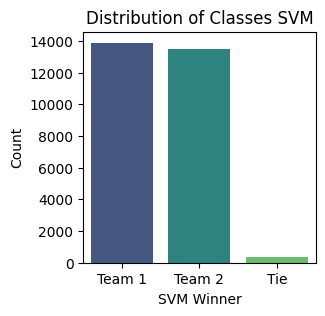

In [33]:
plt.figure(figsize=(3, 3))
sns.countplot(x='SVM Winner', data=y_test_pred_df, palette='viridis')

# Adding labels and title
plt.ylabel('Count')
plt.title('Distribution of Classes SVM')
plt.show()

In [34]:
y_test_pred_df.value_counts(normalize=True)

SVM Winner
Team 1        0.500000
Team 2        0.486106
Tie           0.013894
Name: proportion, dtype: float64

Trained a bagging classifier using SVCS i.e. ensemble method training multiple SVCs

Tuned hyperparameter of number of SVCs to train

N: 1, Train Accuracy 0.9341063741147063, Validation Accuracy: 0.7657290895632864
N: 101, Train Accuracy 0.9916678239133454, Validation Accuracy: 0.8082901554404145
N: 201, Train Accuracy 0.9915289543119011, Validation Accuracy: 0.8090303478904515
N: 301, Train Accuracy 0.9919455631162338, Validation Accuracy: 0.8112509252405625
N: 401, Train Accuracy 0.992014997916956, Validation Accuracy: 0.8119911176905995
N: 501, Train Accuracy 0.9919455631162338, Validation Accuracy: 0.8123612139156181
N: 601, Train Accuracy 0.9918761283155118, Validation Accuracy: 0.8131014063656551
N: 701, Train Accuracy 0.9918761283155118, Validation Accuracy: 0.8134715025906736
N: 801, Train Accuracy 0.9919455631162338, Validation Accuracy: 0.8138415988156921
N: 901, Train Accuracy 0.9919455631162338, Validation Accuracy: 0.8134715025906736
N: 1001, Train Accuracy 0.992014997916956, Validation Accuracy: 0.8138415988156921
Best score: 0.81
Best Gamma: {best_g}
Best accuracy is: 0.8138415988156921 and estimators 

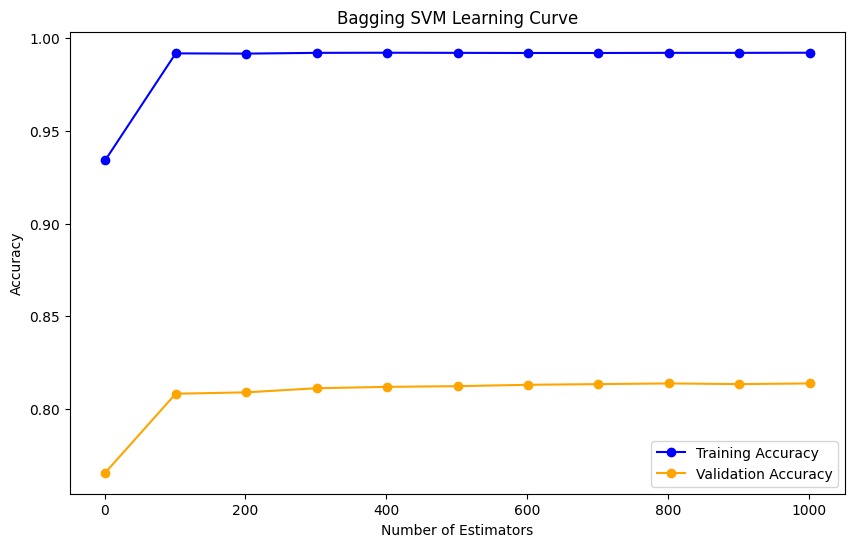

In [ ]:
from sklearn.ensemble import BaggingClassifier

best_accuracy=0
n_list= []
train_acc_list = []
val_acc_list = []

model = SVC(kernel="rbf", random_state=7, C=200, gamma=1.6)
model.fit(X_ss_train_sample, y_ss_train_sample)

for n in range(1, 1002, 100):
    n_list.append(n)
    bagging_model = BaggingClassifier(estimator=model, n_estimators=n, random_state=7)
    bagging_model.fit(X_ss_train_sample, y_ss_train_sample)


    y_train_pred = bagging_model.predict(X_ss_train_sample)
    y_val_pred= bagging_model.predict(X_ss_val_sample)
    train_accuracy = accuracy_score(y_ss_train_sample, y_train_pred)
    val_accuracy = accuracy_score(y_ss_val_sample, y_val_pred)

    train_acc_list.append(train_accuracy)
    val_acc_list.append(val_accuracy)

    print(f"N: {n}, Train Accuracy {train_accuracy}, Validation Accuracy: {val_accuracy}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_n = n

print("Best score: {:.2f}".format(best_accuracy))
print("Best Gamma: {best_g}")
    
n_df = pd.DataFrame({'Num Estimators': n_list, 'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})
print(f"Best accuracy is: {best_accuracy} and estimators is {best_n}")

plt.figure(figsize=(10, 6))
plt.title('Bagging SVM Learning Curve')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.plot(n_df['Num Estimators'], n_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(n_df['Num Estimators'], n_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.ylim(0.7, 1)
plt.legend()
plt.show()

In [ ]:
n_df

,Num Estimators,Train Accuracy,Validation Accuracy
0,1,0.934106,0.765729
1,101,0.991668,0.808290
2,201,0.991529,0.809030
3,301,0.991946,0.811251
4,401,0.992015,0.811991
5,501,0.991946,0.812361
6,601,0.991876,0.813101
7,701,0.991876,0.813472
8,801,0.991946,0.813842
9,901,0.991946,0.813472


Cannot use the full dataset because of computational cost but if that weren't an issue would train the below to compare accuracy to one SVC.

In [ ]:
final_bagging_model = BaggingClassifier(estimator=model, n_estimators=100, random_state=7)
final_bagging_model.fit(X_ss_train_sample, y_ss_train_sample)


y_train_pred = bagging_model.predict(X_ss_train_sample)
y_val_pred= bagging_model.predict(X_ss_val_sample)
train_accuracy = accuracy_score(y_ss_train_sample, y_train_pred)
val_accuracy = accuracy_score(y_ss_val_sample, y_val_pred)

print(f"N: {n}, Train Accuracy {train_accuracy}, Validation Accuracy: {val_accuracy}")

https://datascience.stackexchange.com/questions/66216/gridsearch-without-cv